In [74]:
import pickle as pkl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import imdb


from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model

### Get postive samples

In [2]:
drugbank = pkl.load(open('data/drugbank_embds.pkl', 'rb'))

In [3]:
drugbank['target_gene_code'] = drugbank['target_gene'].apply(lambda x: ''.join(list(x.split('\n')[1:])))
drugbank['target_amino_code'] = drugbank['target_amino'].apply(lambda x: ''.join(list(x.split('\n')[1:])))

In [4]:
with open ('data/chem_cid_SMILE_fngr_vector_fngr.pickle', 'rb') as f:
    smiles_df = pkl.load(f)
    
smiles_df['cid'] = smiles_df['cid'].astype(int)
drugbank = pd.merge(smiles_df, drugbank, right_on = 'pubchem_id', left_on = 'cid', how = 'right')

In [5]:
drugbank = drugbank[['drug_id', 'target_id', 'fingerprint', 'target_gene_code']]
drugbank = drugbank[~ drugbank['fingerprint'].isna()]
drugbank = drugbank.rename(columns = {'fingerprint': 'drug_fingerprint_code', 'target_id': 'gene_id'})

In [6]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...
...,...,...,...,...
14071,DB02843,BE0001369,2245384272 3153477100 2976033787 1916236386 29...,ATGAGCACTGTAAAAGCACCGACGCTGCCCGCCAGCATCTTCCGCG...
14072,DB02843,BE0000916,2245384272 3153477100 2976033787 1916236386 29...,ATGTCCCGGCCCCTGTCAGACCAAGAGAAAAGAAAGCAAATCAGTG...
14073,DB02843,BE0002493,2245384272 3153477100 2976033787 1916236386 29...,ATGAAACGCAAGGGCATCATCCTCGCCGGAGGCTCGGGCACCCGCC...
14074,DB02843,BE0001698,2245384272 3153477100 2976033787 1916236386 29...,ATGTCACAACCTATTTTTAACGATAAGCAATTTCAGGAAGCGCTTT...


### Get DrugID -> Finderprint mapping from positive samples

In [7]:
drug_map = drugbank[['drug_id', 'drug_fingerprint_code']].drop_duplicates('drug_id').set_index('drug_id')
target_map = drugbank[['gene_id', 'target_gene_code']].drop_duplicates('gene_id').set_index('gene_id')

In [8]:
negative_df = pd.read_csv('negative_samples/negative_samples_thrsh:12')[['node_0','node_1','shortest_path']] 
negative_df = negative_df.rename(columns = {'node_0': 'drug_id', 'node_1': 'gene_id'})
negative_df = negative_df[negative_df['drug_id'].str.contains('DB') & negative_df['gene_id'].str.contains('BE')]

In [9]:
negative_df = pd.merge(negative_df, drug_map, left_on = 'drug_id', right_index = True, how = 'left')
negative_df = pd.merge(negative_df, target_map, left_on = 'gene_id', right_index = True, how = 'left')

In [10]:
negative_df.head()

,drug_id,gene_id,shortest_path,drug_fingerprint_code,target_gene_code
1,DB04481,BE0002266,12.0,2245384272 4022716898 2245273601 1735424888 22...,ATGGCGACCTCCACGGGTCGCTGGCTTCTCCTCCGGCTTGCACTAT...
3,DB04481,BE0000206,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGTTTGACTGTATGGATGTTCTGTCAGTGAGTCCTGGGCAAATCC...
4,DB04481,BE0002401,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGGCAGCAGACCTGGGCCCCTGGAATGACACCATCAATGGCACCT...
6,DB04481,BE0004180,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGACGGAAAACAAAGGATCTTCTCAGCCTAAGAAAAACGGTAATA...
10,DB04481,BE0002840,12.0,2245384272 4022716898 2245273601 1735424888 22...,ATGAAATTTCTTCTGGACATCCTCCTGCTTCTCCCGTTACTGATCG...


#### Note: Around 13% of negative samples don't match a drug id. Since the number is small, we ignore it for now

In [11]:
len(negative_df[(negative_df['target_gene_code'].isna()) |
                (negative_df['drug_fingerprint_code'].isna())])/len(negative_df)

negative_df = negative_df[(~ negative_df['target_gene_code'].isna()) &
                (~ negative_df['drug_fingerprint_code'].isna())]

In [12]:
negative_df['Y'] = 0
drugbank['Y'] = 1
drugbank = drugbank.append(negative_df.sample(len(drugbank)))
drugbank = drugbank.drop('shortest_path', axis = 1)

/home/omai.r/.local/lib/python3.5/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
drugbank[drugbank['target_gene_code'].str.contains('S').isna()]

,Y,drug_fingerprint_code,drug_id,gene_id,target_gene_code


In [14]:
drugbank = drugbank[~ drugbank['drug_fingerprint_code'].str.contains('n')]

#### The dataset is clean and balanced

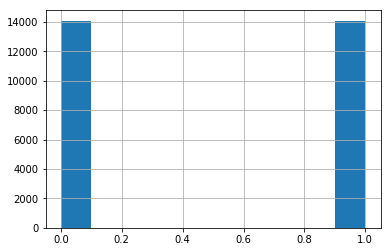

In [15]:
drugbank['Y'].hist()

#### Preprocessing fingerprints to feed to CNN

In [16]:
label_encoder = LabelEncoder()
label_encoder.fit(list(drugbank['target_gene_code'].iloc[0]))

LabelEncoder()

In [17]:
gene_chars = set(list(drugbank['target_gene_code'].iloc[0]))

In [18]:
drugbank['target_gene_encoded'] = drugbank['target_gene_code'].apply(\
                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))

In [19]:
drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].apply(lambda x: [int(i) for i in x.replace(' ', '')])

In [20]:
drugbank.head()

,Y,drug_fingerprint_code,drug_id,gene_id,target_gene_code,target_gene_encoded,drug_fingerprint_encoded
0,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0001349,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
1,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0004335,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
2,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0004290,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
3,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0003624,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
4,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0004644,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."


#### Calculate length mismatches and pad

In [21]:
drugbank['target_gene_encoded_len'] = drugbank['target_gene_encoded']\
                                    .apply(lambda x: len(x))
drugbank['drug_fingerprint_encoded_len'] = drugbank['drug_fingerprint_encoded']\
                                    .apply(lambda x: len(x))

In [22]:
drugbank['mismatch'] = drugbank[['target_gene_encoded', 'drug_fingerprint_encoded']]\
                        .apply(lambda x: len(x['target_gene_encoded']) - len(x['drug_fingerprint_encoded']), axis = 1)

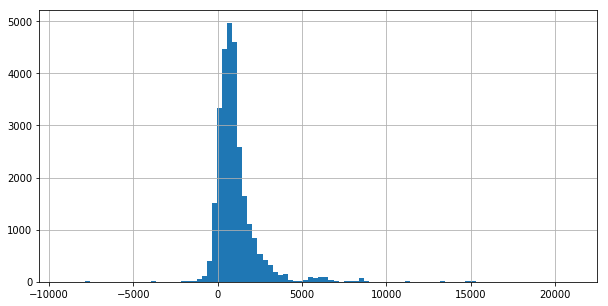

In [23]:
drugbank['mismatch'].hist(bins = 100, figsize = (10, 5))

In [24]:
print('95 percent of the mismatches are of the range %f to %f' % (max(drugbank['mismatch'].value_counts()) - np.std(drugbank['mismatch'].value_counts()),
                                                           max(drugbank['mismatch'].value_counts()) + np.std(drugbank['mismatch'].value_counts())))

95 percent of the mismatches are of the range 22.998257 to 35.001743


In [25]:
max_target_gene_encoded_len = max(drugbank['target_gene_encoded_len'])
max_drug_fingerprint_encoded_len = max(drugbank['drug_fingerprint_encoded_len'])

In [26]:
drugbank['target_gene_encoded_mismatch'] = max_target_gene_encoded_len - drugbank['target_gene_encoded_len']

In [27]:
drugbank['drug_fingerprint_encoded_mismatch'] = max_drug_fingerprint_encoded_len - drugbank['drug_fingerprint_encoded_len'] 

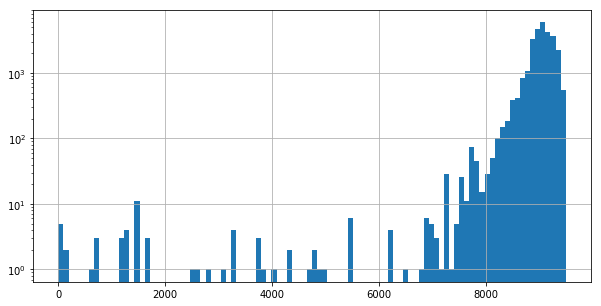

In [28]:
drugbank['drug_fingerprint_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

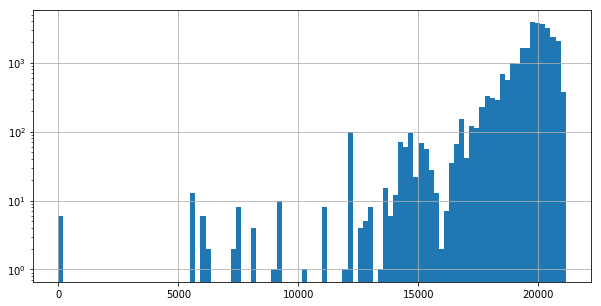

In [29]:
drugbank['target_gene_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

#### There appears to be quite large intracolumn mismatches in length. Unsure how to deal with it now. Current strategy is to pad the inputs and model it

In [38]:
drugbank['target_gene_encoded_padded'] = drugbank[['target_gene_encoded','target_gene_encoded_mismatch']]\
                                         .apply(lambda x: ['-1' for i in range(int(x['target_gene_encoded_mismatch']/2))] +   
                                                        list(x['target_gene_encoded']) +
                                                        ['-1' for i in range (int(x['target_gene_encoded_mismatch']/2))]
                                                        , axis = 1)
drugbank['target_gene_encoded_padded'] = drugbank['target_gene_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_target_gene_encoded_len else x)

In [39]:
drugbank['drug_fingerprint_encoded_padded'] = drugbank[['drug_fingerprint_encoded','drug_fingerprint_encoded_mismatch']]\
                                         .apply(lambda x: ['-1' for i in range(int(x['drug_fingerprint_encoded_mismatch']/2))] +   
                                                        list(x['drug_fingerprint_encoded']) +
                                                        ['-1' for i in range (int(x['drug_fingerprint_encoded_mismatch']/2))]
                                                        , axis = 1)

drugbank['drug_fingerprint_encoded_padded'] = drugbank['drug_fingerprint_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_drug_fingerprint_encoded_len else x)

In [4]:
drugbank.to_csv('data/intermediate/interactions_preprocessed.csv', index = False)

In [48]:
del smiles_df, negative_df

## Building a CNN

In [3]:
drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

#drugbank = drugbank.sample(7500)

In [ ]:
drugbank = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)
drugbank_test = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)

In [2]:
drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

In [3]:
drugbank = drugbank_reader.sample(7500, replace = False)
drugbank_test = drugbank_reader.sample(7500, replace = False)


In [4]:
drugbank['target_gene_encoded_padded'][0]

array(['-1', '-1', '-1', ..., '-1', '-1', '-1'], dtype='<U2')

In [21]:
X_0 = np.array(list(drugbank['target_gene_encoded_padded'])).astype(int)
X_1 = np.array(list(drugbank['drug_fingerprint_encoded_padded'])).astype(int)
Y   = np.array(list(drugbank['Y'])).astype(int)

In [22]:
X_0_test = np.array(list(drugbank_test['target_gene_encoded_padded'])).astype(int)
X_1_test = np.array(list(drugbank_test['drug_fingerprint_encoded_padded'])).astype(int)
Y_test   = np.array(list(drugbank_test['Y'])).astype(int)

In [23]:
X_0.shape

(7500, 21222)

In [24]:
X_0_test.shape

(7500, 21222)

#### Trimming the feature martrix to minimize padding. This trimming may result in loss of data from the largest SMILE and fingerprints, but are neccesary to reduce the amount of padding

In [41]:
## Trim the X of -1's. Might loose actual sequences
padding_fractions = []
padding_fraction = 0.9

while padding_fraction > 0.5:
    
    padding_fraction = len(X_0[np.where(X_0 == -1)]) / (X_0.shape[0] * X_0.shape[1])
    padding_fractions.append(padding_fraction)
    trimming_factor = 0.1

    X_0 = X_0[:,int(X_0.shape[1]*trimming_factor) : X_0.shape[1] - int(X_0.shape[1]*trimming_factor)]
    X_1 = X_1[:,int(X_1.shape[1]*trimming_factor) : X_1.shape[1] - int(X_1.shape[1]*trimming_factor)]

    X_0_test = X_0_test[:,int(X_0_test.shape[1]*trimming_factor) : X_0_test.shape[1] - int(X_0_test.shape[1]*trimming_factor)]
    X_1_test = X_1_test[:,int(X_1_test.shape[1]*trimming_factor) : X_1_test.shape[1] - int(X_1_test.shape[1]*trimming_factor)]


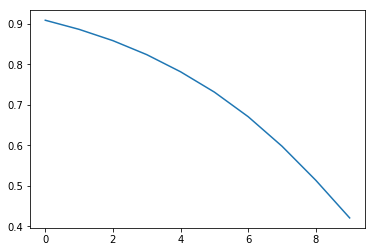

In [42]:
plt.plot(padding_fractions)

In [43]:
X_0.shape

(7500, 1828)

In [44]:
X_0_test.shape

(7500, 1828)

In [45]:
X_0 = np.hstack((X_0, X_1))
X_0_test = np.hstack((X_0_test, X_1_test))

In [46]:
X_0.shape

(7500, 2649)

In [47]:
X_0_test.shape

(7500, 2649)

In [7]:
del drugbank, drugbank_test, drugbank_reader

In [48]:
#embedding_dims = 16
hidden_dims = 512
hidden_dims_2 = 256
hidden_dims_3 = 128
batch_size = 500
epochs = 80
#maxlen = 

model = Sequential()
#model.add(Embedding(X_0.shape[1],
#                    embedding_dims,
#                    input_length=maxlen))

#model.add(Dropout(0.2))
model.add(Conv1D(X_0.shape[0],
                 X_0.shape[1],
                 activation='relu',
                 strides=10))

model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_2))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_3))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_0[..., np.newaxis], Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_0_test[..., np.newaxis], Y_test))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7500 samples, validate on 7500 samples
Epoch 1/80
7500/7500 [==============================] - 54s 7ms/step - loss: 3.9163 - acc: 0.5136 - val_loss: 0.8240 - val_acc: 0.5585
Epoch 2/80
7500/7500 [==============================] - 50s 7ms/step - loss: 1.1649 - acc: 0.5133 - val_loss: 0.6830 - val_acc: 0.5649
Epoch 3/80
7500/7500 [==============================] - 50s 7ms/step - loss: 0.7266 - acc: 0.5492 - val_loss: 0.6647 - val_acc: 0.5905
Epoch 4/80
7500/7500 [==============================] - 52s 7ms/step - loss: 0.6828 - acc: 0.5684 - val_loss: 0.6566 - val_acc: 0.6096
Epoch 5/80
7500/7500 [==============================] - 50s 7ms/step - loss: 0.6567 - acc: 0.6047 - val_loss: 0.6292 - val_acc: 0.6519
Epoch 6/80
7500/7500 [==============================] - 50s 7m

KeyboardInterrupt: 

In [51]:
Y_pred = model.predict(X_0_test[..., np.newaxis])

In [57]:
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

In [61]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
cm = confusion_matrix(Y_test, Y_pred)

In [71]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[2788  930]
 [ 579 3203]]
Normalized confusion matrix
[[0.74986552 0.25013448]
 [0.1530936  0.8469064 ]]


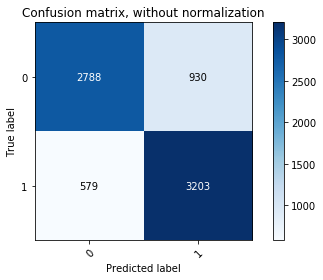

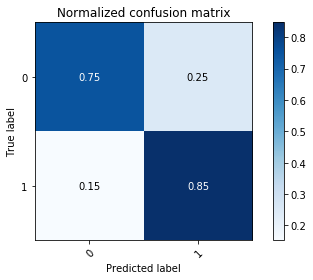

In [72]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [76]:
f1_score(Y_test, Y_pred)

0.8093493367024637